# 各種インポート

In [369]:
import pandas as pd
import time
from tqdm.notebook import tqdm as tqdm
import requests
from bs4 import BeautifulSoup
import re
import numpy as np

# Update関数

In [596]:
def update(func, update_id_list, old_data, merge=False):
    new_id_list = set(update_id_list) - (set(update_id_list) & set(old_data.index.unique().values))
    if len(new_id_list)==0:
        print('重複はありません')
    else:
        df = func(new_id_list)
        if merge:
            df = pd.concat([df, old_data])    
        return df

# データ取得

## レース結果取得

### 取得するレースのidを指定

In [4]:
race_id_list = []
for place in range(1,11,1):
    for kai in range(1,6,1):
        for day in range(1,9,1):
            for r in range(1,13,1):
                race_id = '2019' + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

年＋場所（01:札幌,02:函館,03:福島,04:新潟,05:東京,06:中山,07:中京,08:京都,09:阪神,10:小倉）＋回＋月日＋ラウンド

### スクレイピング

In [456]:
def scraping_race_result(id_list, pre_race_results={}):
    race_results = pre_race_results
    
    for race_id in tqdm(id_list):
        if race_id in pre_race_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/race/' + race_id
            df = pd.read_html(url)[0]
            
            #horse_idとjockey_idを入れる
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            
            horse_id_list = []
            horse_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
                
            jockey_id_list = []
            jockey_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])
                
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
            time.sleep(0.2)
        except IndexError:
            continue
        except:
            break
            
    for key in race_results.keys():
        race_results[key].index = [key]*len(race_results[key])
    race_results = pd.concat([race_results[key] for key in race_results.keys()],sort=False)  
    
    return race_results

### スクレイピング後のデータ

In [366]:
results = pd.read_pickle('results_2020.pickle')
results.head()

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id
202106030811,1,4,7,エフフォーリア,牡3,57.0,横山武史,2:00.6,NaN,3.7,2.0,504(-10),[東] 鹿戸雄一,2018105027,01170
202106030811,2,7,13,タイトルホルダー,牡3,57.0,田辺裕信,2:01.1,3,17,8.0,462(-4),[東] 栗田徹,2018103559,01075
202106030811,3,2,3,ステラヴェローチェ,牡3,57.0,吉田隼人,2:01.1,クビ,14.3,6.0,500(0),[西] 須貝尚介,2018104980,01095
202106030811,4,1,1,アドマイヤハダル,牡3,57.0,ルメール,2:01.2,クビ,8.8,3.0,482(-2),[西] 大久保龍,2018105092,05339
202106030811,5,3,6,ヨーホーレイク,牡3,57.0,岩田望来,2:01.2,クビ,21.5,11.0,504(-2),[西] 友道康夫,2018105012,01174


## レース情報取得

### 実際に取得できたレースのid

In [33]:
results.index.unique()

Index(['202106030811', '202001010101', '202001010102', '202001010103',
       '202001010104', '202001010105', '202001010106', '202001010107',
       '202001010108', '202001010109',
       ...
       '202010020803', '202010020804', '202010020805', '202010020806',
       '202010020807', '202010020808', '202010020809', '202010020810',
       '202010020811', '202010020812'],
      dtype='object', length=3121)

### スクレイピング

In [9]:
def scrape_race_info(race_id_list):
    race_infos = {}
    
    for race_id in tqdm(race_id_list):
        try:
            url = 'https://db.netkeiba.com/race/' +race_id
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            texts = soup.find('div',attrs=['class','data_intro']).find_all('p')[0].text + \
                soup.find('div',attrs=['class','data_intro']).find_all('p')[1].text
            info = re.findall(r'\w+', texts)
            #infoに含まれるtextの内容によって項目を判断
            info_dict = {}
            for text in info:
                if text in ['芝','ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = re.findall(r'\d+',text)[0]
                if text in ['良','稍重','重','不良']:
                    info_dict['ground_state'] = text
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text
            race_infos[race_id] = info_dict
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return pd.DataFrame(race_infos).T

### スクレイピング後のデータ

In [460]:
race_infos = pd.read_pickle('race_infos.pickle')
race_infos.head()

,course_len,date,ground_state,race_type,weather
202106030811,2000,2021年4月18日,稍重,芝,晴
202001010101,1800,2020年7月25日,良,芝,曇
202001010102,1700,2020年7月25日,良,ダート,曇
202001010103,1500,2020年7月25日,良,芝,曇
202001010104,1700,2020年7月25日,良,ダート,曇


### レース結果にマージ

In [368]:
results_m = results.merge(race_infos, left_index=True, right_index=True, how='inner')

In [370]:
results_m.to_pickle('results_m_2020.pickle')

### データ更新時

In [465]:
update_id_list = pd.read_pickle('results_2019.pickle').index.unique()
race_info_2019 = update(scrape_race_info, update_id_list, race_info_2019, merge=True)

In [468]:
results_m_2019 = pd.read_pickle('results_2019.pickle').merge(race_info_2019, left_index=True, right_index=True, how='inner')
results_m_2019

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id,course_len,weather,race_type,ground_state,date
201901010101,1,1,1,ゴルコンダ,牡2,54.0,ルメール,1:48.3,NaN,1.4,1.0,518(-16),[東] 木村哲也,2017105318,05339,1800,曇,芝,良,2019年7月27日
201901010101,2,3,3,プントファイヤー,牡2,54.0,岩田康誠,1:50.1,大,3.5,2.0,496(-8),[東] 手塚貴久,2017104612,05203,1800,曇,芝,良,2019年7月27日
201901010101,3,4,4,ラグリマスネグラス,牡2,51.0,団野大成,1:50.9,5,46.6,6.0,546(+6),[東] 藤沢和雄,2017103879,01180,1800,曇,芝,良,2019年7月27日
201901010101,4,8,9,キタノコドウ,牡2,51.0,菅原明良,1:51.5,3.1/2,56.8,7.0,458(-8),[東] 高木登,2017106259,01179,1800,曇,芝,良,2019年7月27日
201901010101,5,5,5,ネモフィラブルー,牡2,54.0,川島信二,1:51.7,1.1/2,140.3,9.0,436(0),[西] 矢作芳人,2017104140,01062,1800,曇,芝,良,2019年7月27日
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910020812,10,7,12,オーシャンスケイプ,牝3,52.0,大野拓弥,1:49.8,3/4,45.7,10.0,414(+6),[西] 西村真幸,2016104557,01096,1800,曇,芝,良,2019年8月18日
201910020812,11,3,3,プリヴェット,牝4,55.0,藤岡康太,1:50.3,3,29.8,9.0,486(+2),[西] 今野貞一,2015101367,01116,1800,曇,芝,良,2019年8月18日
201910020812,12,5,7,アドマイヤクィーン,牝4,55.0,松山弘平,1:50.3,クビ,29.6,8.0,476(+6),[西] 須貝尚介,2015104794,01126,1800,曇,芝,良,2019年8月18日
201910020812,13,8,13,タムロドリーム,牝3,49.0,亀田温心,1:50.4,1/2,134.8,12.0,472(+2),[西] 西園正都,2016102212,01176,1800,曇,芝,良,2019年8月18日


In [470]:
results_m_2019.to_pickle('results_m_2019.pickle')

## 馬ごとの過去成績を取得

### 取得する馬のidを指定

In [436]:
horse_id_list = results_m['horse_id'].unique()
len(horse_id_list)

11389

### スクレイピング

In [598]:
def scraping_horse_result(id_list, pre_horse_results={}):
    horse_results = pre_horse_results
    
    for horse_id in tqdm(id_list):
        if horse_id in horse_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
            horse_results[horse_id] = df
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    
    #辞書型からデータフレーム型に変換        
    for key in horse_results.keys():
        horse_results[key].index = [key]*len(horse_results[key])
    horse_results = pd.concat([horse_results[key] for key in horse_results.keys()],sort=False)  
    
    return horse_results

### スクレイピング後のデータ

In [475]:
horse_results = pd.read_pickle('horse_results.pickle')
horse_results.index.nunique()

11389

### データ更新時

In [476]:
horse_id_list = r.results_p['horse_id'].unique()
horse_results_new = update(scraping_horse_result, horse_id_list, horse_results, merge=True)

In [548]:
horse_results_new.index.nunique()

16162

In [480]:
horse_results_new.to_pickle('horse_results.pickle')

## 払戻しデータを取得

In [630]:
from urllib.request import urlopen

def scraping_return_tables(id_list, pre_return_table={}):
    return_tables = pre_return_table
    for race_id in tqdm(id_list):
        if race_id in pre_return_table.keys():
            continue
        try:
            url='https://db.netkeiba.com/race/' + race_id
            f = urlopen(url)
            html = f.read()#バイト型の文字列
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
            
    for key in return_tables.keys():
        return_tables[key].index = [key]*len(return_tables[key])
        
    return_tables_pd = pd.concat([return_tables[key] for key in return_tables.keys()],sort=False)
    return return_tables_pd

### スクレイピング後のデータ

In [633]:
return_tables_2020 = scraping_return_tables(results_new.index.unique())

In [643]:
return_tables_2020.to_pickle('return_tables_2020.pickle')

### データ更新時

In [626]:
results_new = pd.read_pickle('results_2020.pickle')

In [627]:
results_new.index.nunique()

3121

In [446]:
return_tables_2020 = update(scraping_return_tables, results_new.index.unique(), return_tables_new, merge=True)

### Returnクラス

In [350]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @property
    def tan(self):
        tan = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tan.columns = ['win', 'return']
        tan['return'] = tan['return'].str.replace(',','')
        return tan.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする
    
    @property
    def fuku(self):
        fuku = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        #勝ち馬の馬番
        wins = fuku[1].str.split('br', expand = True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        #払い戻し
        returns = fuku[2].str.split('br', expand = True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0] == '馬単'][[1,2]]
        wins = umatan[1].str.split('→', expand = True)[[0,1]].add_prefix('win_')
        returns = umatan[2].rename('return')
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand = True)[[0,1]].add_prefix('win_')
        returns = umaren[2].rename('return')
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        df['return'] = df['return'].str.replace(',','')
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0] == 'ワイド'][[1,2]]
        #勝ち馬の馬番
        wins = wide[1].str.split('br', expand = True)[[0,1,2]].stack().str.split('-', expand = True).add_prefix('win_')
        #払い戻し
        returns = wide[2].str.split('br', expand = True)[[0, 1, 2]].stack().rename('return')
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        df['return'] = df['return'].str.replace(',','')
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする
    
    @property
    def sanrentan(self):
        sanrentan = self.return_tables[self.return_tables[0] == '三連単'][[1,2]]
        wins = sanrentan[1].str.split('→', expand = True)[[0,1,2]].add_prefix('win_')
        returns = sanrentan[2].rename('return')
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする
    
    @property
    def sanrenfuku(self):
        sanrenfuku = self.return_tables[self.return_tables[0] == '三連複'][[1,2]]
        wins = sanrenfuku[1].str.split('-', expand = True)[[0,1,2]].add_prefix('win_')
        returns = sanrenfuku[2].rename('return')
        df = pd.concat([wins, returns], axis=1)
        #4桁の数字の桁区切りをなくす
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする

In [644]:
return_tables = Return.read_pickle(['return_tables_2019.pickle', 'return_tables_2020.pickle']).return_tables

In [645]:
return_tables.index.nunique()

6309

## 血統データ取得

### スクレイピング

In [481]:
def scraping_peds(id_list, pre_peds={}):
    peds = pre_peds
    
    for horse_id in tqdm(id_list):
        if horse_id in pre_peds.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/ped/' + horse_id
            df = pd.read_html(url)[0]
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i] #若い世代から順に
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
                
            ped = pd.concat(generations[i] for i in range(5)).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(0.2)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
            
    #データフレーム型に変換
    peds = pd.concat([peds[horse_id] for horse_id in peds], axis=1).T
    peds = peds.add_prefix('peds_')
    
    return peds

### スクレイピング後のデータ

In [455]:
horse_id_list = horse_results.index.unique()
peds = scraping_peds(horse_id_list)

In [482]:
peds = Peds.read_pickle(['peds.pickle']).peds
peds.head()

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,ゴールドシップ 2009 芦毛 [血統][産駒] Halo系,コスモエルデスト 2011 鹿毛 [血統][産駒] FNo.[14-f],ステイゴールド 1994 黒鹿毛 [血統][産駒],ポイントフラッグ 1998 芦毛 [血統][産駒],ブラックホーク 1994 鹿毛 [血統][産駒],ビューティアイ 2005 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],メジロマックイーン 1987 芦毛 [血統][産駒],パストラリズム 1987 黒鹿毛 [血統][産駒],...,Chieftain,Level Sands,Halo,Wishing Well,Carr de Naskra,Mawgrit,Danzig,Razyana,リアルシャダイ,マックスビューティ
2018105193,ディープインパクト 2002 鹿毛 [血統][産駒] Halo系,ヒストリックスター 2005 鹿毛 [血統][産駒] FNo.[9-f],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ベガ 1990 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Alzao 1980 鹿毛 [血統][産駒],Burghclere 1977 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Kalamoun,State Pension,Hornbeam,Priddy Fair,Nearctic,Natalma,Tom Fool,Brazen
2018104800,スクリーンヒーロー 2004 栗毛 [血統][産駒] Roberto系,マルバイユ Marbye(愛) 2000 鹿毛 [血統][産駒] FNo.[9-f],グラスワンダー 1995 栗毛 [血統][産駒],ランニングヒロイン 1993 鹿毛 [血統][産駒],Marju 1988 黒鹿毛 [血統][産駒],Hambye 1994 鹿毛 [血統][産駒],Silver Hawk 1979 鹿毛 [血統][産駒],Ameriflora 1989 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ダイナアクトレス 1983 鹿毛 [血統][産駒],...,Welsh Pageant,Electric Flash,Sir Gaylord,Little Hut,Claude,Ribasha,Thatch,Last Call,Mummy's Pet,Goosie-Gantlet
2018102410,キズナ 2010 青鹿毛 [血統][産駒] Halo系,ヴィアレッタ 2011 鹿毛 [血統][産駒] FNo.[14-c],ディープインパクト 2002 鹿毛 [血統][産駒],キャットクイル Catequil(加) 1990 鹿毛 [血統][産駒],Pivotal 1993 栗毛 [血統][産駒],ヴァレッタ Valletta(英) 2006 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Pacific Princess 1973 鹿毛 [血統][産駒],...,Bustino,Zerbinetta,Danzig,Foreign Courier,Ahonoora,Balidaress,Arctic Tern,Beaune,Nureyev,Unite
2018100828,リオンディーズ 2013 黒鹿毛 [血統][産駒] Mr. Prospector系,スマートエンデバー 2010 栗毛 [血統][産駒] FNo.[12-c],キングカメハメハ 2001 鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ディスコホール 1989 栗毛 [血統][産駒],Kingmambo (米) 1990 鹿毛 [血統][産駒],マンファス Manfath(愛) 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Nearctic,Natalma,Victoria Park,Lady Angela,Herbager,Silver Sari,Crimson Satan,Bright Prospect


### データ更新時

In [484]:
new_horse_id_list = r.results['horse_id'].unique()
new_peds = update(scraping_peds, new_horse_id_list, peds, merge=True)

In [487]:
new_peds

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2014103674,ハーツクライ 2001 鹿毛 [血統][産駒] Halo系,ボンビバン 2007 黒鹿毛 [血統][産駒] FNo.[1-s],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],アイリッシュダンス 1990 鹿毛 [血統][産駒],Red Ransom 1987 鹿毛 [血統][産駒],アーキオロジー Archeology(米) 2002 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ビューパーダンス Buper Dance(米) 1983 黒鹿毛 [血統][産駒],...,Nearctic,Bally Free,Raise a Native,Gold Digger,Buckpasser,Broadway,Storm Bird,Terlingua,Affirmed,La Mesa
2016104869,ノヴェリスト Novellist(愛) 2009 黒鹿毛 [血統][産駒] Blandford系,ライラプス 2002 栗毛 [血統][産駒] FNo.[20-a],Monsun 1990 黒鹿毛 [血統][産駒],Night Lagoon 2001 黒鹿毛 [血統][産駒],フレンチデピュティ French Deputy(米) 1992 栗毛 [血統][産駒],フサイチエアデール 1996 黒鹿毛 [血統][産駒],Konigsstuhl 1976 青毛 [血統][産駒],Mosella 1985 鹿毛 [血統][産駒],Lagunas 1981 黒鹿毛 [血統][産駒],Nenuphar 1994 黒鹿毛 [血統][産駒],...,Bold Ruler,Fortunate Isle,Hail to Reason,Cosmah,Understanding,Mountain Flower,Raise a Native,Gold Digger,Francis S.,Swinging Doll
2016100577,シンボリクリスエス 1999 黒鹿毛 [血統][産駒] Roberto系,ヤマニンファビュル 2003 栗毛 [血統][産駒] FNo.[1-w],Kris S. 1977 黒鹿毛 [血統][産駒],Tee Kay 1991 黒鹿毛 [血統][産駒],エアジハード 1995 栗毛 [血統][産駒],マダニナ 1991 鹿毛 [血統][産駒],Roberto 1969 鹿毛 [血統][産駒],Sharp Queen 1965 鹿毛 [血統][産駒],Gold Meridian 1982 黒鹿毛 [血統][産駒],Tri Argo 1982 黒鹿毛 [血統][産駒],...,ノーザンテースト,サワーオレンジ,Nearctic,Natalma,Bold Reason,Special,Red God,Runaway Bride,Luthier,Riverside
2013105680,ジャングルポケット 1998 鹿毛 [血統][産駒] ゼダーン系,メイカ 2004 鹿毛 [血統][産駒] FNo.[1-n],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ダンスチャーマー Dance Charmer(米) 1990 黒鹿毛 [血統][産駒],ダンスインザダーク 1993 鹿毛 [血統][産駒],フラワーパーク 1992 鹿毛 [血統][産駒],カンパラ Kampala(英) 1976 黒鹿毛 [血統][産駒],Severn Bridge 1965 栗毛 [血統][産駒],Nureyev 1977 鹿毛 [血統][産駒],Skillful Joy 1979 栗毛 [血統][産駒],...,Key to the Mint,Native Partner,Habitat,A. 1.,チャイナロック,ライトフレーム,Northern Dancer,Lady Victoria,Dike,Pascha
2013105952,キングカメハメハ 2001 鹿毛 [血統][産駒] Mr. Prospector系,ソニックグルーヴ 2003 鹿毛 [血統][産駒] FNo.[8-f],Kingmambo (米) 1990 鹿毛 [血統][産駒],マンファス Manfath(愛) 1991 黒鹿毛 [血統][産駒],フレンチデピュティ French Deputy(米) 1992 栗毛 [血統][産駒],エアグルーヴ 1993 鹿毛 [血統][産駒],Mr. Prospector 1970 鹿毛 [血統][産駒],Miesque 1984 鹿毛 [血統][産駒],ラストタイクーン Last Tycoon(愛) 1983 黒鹿毛 [血統][産駒],Pilot Bird 1983 鹿毛 [血統][産駒],...,Bold Ruler,Fortunate Isle,Kalamoun,State Pension,Hornbeam,Priddy Fair,Northern Dancer,Lady Victoria,ガーサント,パロクサイド
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018109169,スクワートルスクワート Squirtle Squirt(米) 1998 黒鹿毛 [血統][産...,サキノザザ 2009 栗毛 [血統][産駒] FNo.[20-a],Marquetry 1987 栗毛 [血統][産駒],Lost the Code 1990 鹿毛 [血統][産駒],タイムパラドックス 1998 栗毛 [血統][産駒],サキノローレル 2004 鹿毛 [血統][産駒],Conquistador Cielo 1979 鹿毛 [血統][産駒],Regent's Walk 1981 栗毛 [血統][産駒],Lost Code 1984 黒鹿毛 [血統][産駒],Smarter By the Day 1983 黒鹿毛 [血統][産駒],...,ボールドラツド,Tredam,Blushing Groom,I Will Follow,Saint Cyrien,Bold Lady,ノーザンテースト,アスコツトラップ,エイトラックス,ジユテイフア
2017104830,ジャスタウェイ 2009 鹿毛 [血統][産駒] Halo系,ディオニージア Dionisia(米) 2003 黒鹿毛 [血統][産駒] FNo.[22-c],ハーツクライ 2001 鹿毛 [血統][産駒],シビル 1999 鹿毛 [血統][産駒],Tejano Run 1992 栗毛 [血統][産駒],Essie's Maid 1988 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],アイリッシュダンス 1990 鹿毛 [血統][産駒],Wild Again 1980 黒鹿毛 [血統][産駒],シャロン Charon(米) 1987 栗毛 [血統][産駒],...,Green Dancer,Khazaeen,Tom Rolfe,Wavy Navy,Cyane,Rum Bottle Bay,Intent,My Recipe,Irish Lancer,Esoteric
2017101519,トゥザワールド 2011 鹿毛 [血統][産駒] Mr. Prospector系,ブルーライトクロス 2012 鹿毛 [血統][産駒] FNo.[3-e],キングカメハメハ 2001 鹿毛 [血統][産駒],トゥザヴィクトリー 1996 鹿毛 [血統][産駒],ファスリエフ Fasliyev(米) 1997 鹿毛 [血統][産駒],セイカドミノ 1996 栗毛 [血統][産駒],Kingmambo (米) 1990 鹿毛 [血統][産駒],マンファス Manfath(愛) 1991 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],フェアリードール Fairy Doll(米) 1991 栗毛 [血統][産駒],...,Never Bend,Repercussion,Riverman,Irish Star,Northfields,ツリーオブノレッジ,Hail to Reason,Cosmah,Understanding,Mountain Flower
2018106621,メイショウサムソン 2003 鹿毛 [血統][産駒] Sadler's Wells系,メイショウモーレン 2009 栗毛 [血統][産駒] FNo.[10-a],オペラハウス Opera House(英) 1988 鹿毛 [血統][産駒],マイヴィヴィアン 1997 鹿毛 [血統][産駒],ステイゴールド 1994 黒鹿毛 [血統][産駒],プリティタイディ 19

In [488]:
new_peds.to_pickle('peds.pickle')

# 前処理

## Resultsクラス

In [582]:
class Results:
    def __init__(self, results):
        self.results = results 
        self.results_p = pd.DataFrame() # 前処理後のデータ
        self.results_hr = pd.DataFrame()  #馬成績マージ後のデータ
        self.results_ped = pd.DataFrame() #血統データマージ後のデータ
        self.results_cat = pd.DataFrame() #カテゴリ変数化、ダミー変数化後のデータ

    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)    
        
    def preprocessing(self):
        df = self.results.copy()
        #着順から数字以外を含むデータを除く
        df = df[-df["着順"].astype(str).str.contains("\D")] 
        #性齢を性と齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
        #馬体重を体重と体重増減に分ける
        df["体重"] = df["馬体重"].str.split('(',expand=True)[0].astype(int)
        df["体重増減"] = df["馬体重"].str.split('(',expand=True)[1].str[:-1].astype(int)
        #型変換と不要列削除
        df["単勝"] = df["単勝"].astype(float)
        df["着順"] = df["着順"].astype(int)
        df["人気"] = df["人気"].astype(int)
        df["rank"] = df["着順"].map(lambda x:1 if x <4 else 0)
        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
        df['course_len'] = df['course_len'].astype(int)
          
        df.drop(["馬名","着順","騎手","単勝","人気", '性齢','馬体重','タイム','着差','調教師'], axis=1,inplace=True)
        self.results_p = df
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.results_hr = self.results_p.copy()
        for n_samples in n_samples_list:
            self.results_hr = hr.merge_all(self.results_hr, n_samples=n_samples)
            
    def merge_peds(self, peds):
        self.results_ped = self.results_hr.merge(peds, left_on='horse_id', right_index=True, how='left')
        
    def process_cat(self):
        df = self.results_ped.copy()
        target_columns = ['horse_id', 'jockey_id']
        #カテゴリ変数化
        for column in target_columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
            df[column] = df[column].astype('category')
        #カテゴリ型の列以外をダミー変数化
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        self.results_cat = df

## 各種データ数確認

In [583]:
r = Results.read_pickle(['results_m_2019.pickle', 'results_m_2020.pickle'])

In [584]:
#レース結果データのレース数
r.results.index.nunique()

6309

In [585]:
#レース結果データの出馬した馬数
r.results['horse_id'].nunique()

16207

In [588]:
#レース結果データの出馬した馬数（前処理後）
r.results_p['horse_id'].nunique() #着順に数字以外を含むデータを除く関係で上と一致しない

16140

In [589]:
horse_results = pd.read_pickle('horse_results.pickle')

In [590]:
#馬戦績データの馬数
horse_results.index.nunique()

16162

In [591]:
set(r.results_p['horse_id'].unique()).issubset(set(horse_results.index.unique()))

True

In [592]:
p = Peds.read_pickle(['peds.pickle'])

In [593]:
p.peds.index.nunique()

16207

In [594]:
#払戻し表のレース数
return_tables.index.nunique()

6309

## 前処理

In [586]:
r.preprocessing()

In [587]:
r.results_p.head()

,枠番,馬番,斤量,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,齢,体重,体重増減,rank
201901010101,1,1,54.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,1
201901010101,3,3,54.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,1
201901010101,4,4,51.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,1
201901010101,8,9,51.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,0
201901010101,5,5,54.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,0


## 馬の過去成績をマージ

### HorseResultsクラス

In [602]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','R','賞金','開催','距離','タイム']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self):
        df = self.horse_results.copy()
        df = df[-df['R'].isnull()]
        df['賞金'] = df['賞金'].fillna(0).astype('int')
        df['日付'] = pd.to_datetime(df['日付'])
        df.rename(columns={'R':'着順'}, inplace=True)
        df['着順'] = df['着順'].astype('int')
        
#         #開催場所
#         place_dict = {'札幌':'01', '函館':'02', '福島':'03', '新潟':'04', '東京':'05', 
#                       '中山':'06', '中京':'07', '京都':'08', '阪神':'09','小倉':'10'}
#         df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
#         #距離
#         df['距離'] = df['距離'].str.extract(r'(\D+)')
#         #タイム
#         def to_second(x):
#             info = re.findall(r'(\d+)', str(x))
#             if len(info)==3:
#                 second = int(info[0]) * 60 + int(info[1])
#             else:
#                 second = 0        
#             return second
        
#         df['タイム'] = df['タイム'].map(lambda x : to_second(x))
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
#         target_df = self.horse_results.query('index in @horse_id_list')
        target_df = self.horse_results[self.horse_results.index.isin(horse_id_list)]
        #平均する対象をレース日付以前のうち直近n_samplesのデータのみに限定する（古いデータを反映させないため）
        if n_samples=='all':
            filtered_df = target_df[target_df['日付'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['日付'] < date].sort_values('日付', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        filtered_df = filtered_df.groupby(level=0)[['着順','賞金']].mean()
        filtered_df.rename(columns={'着順':'着順_{}R'.format(n_samples),'賞金':'賞金_{}R'.format(n_samples)}, inplace=True)
        return filtered_df
    
    def merge(self, results, date, n_samples):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        #レース結果の同じ日付のかたまりごとに1行ずつhorse_idにひもづくその日付以前の戦績の平均を算出し（average）、
        #レース結果のかたまりにマージする(merge)という意味
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)]) 
        return merged_df

In [599]:
update(scraping_horse_result, r.results_p['horse_id'].unique(),horse_results)

重複はありません


In [603]:
hr = HorseResults(horse_results)

In [604]:
r.merge_horse_results(hr)

## 血統データをマージ

### Pedsクラス

In [605]:
from sklearn.preprocessing import LabelEncoder

class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_en = pd.DataFrame()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_en = df.astype('category')

### category型に変換

In [606]:
p.encode()
peds = p.peds_en
peds.head()

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2014103674,452,6965,169,262,401,1946,39,166,238,424,...,238,48,141,131,68,133,402,1104,16,1333
2016104869,446,8007,88,155,832,4964,52,98,90,201,...,46,224,68,71,485,574,333,420,342,2566
2016100577,340,7890,72,231,593,5479,77,133,74,308,...,457,726,118,249,59,827,338,941,546,2174
2013105680,343,7590,196,364,750,5013,102,128,126,272,...,180,444,67,0,542,1056,286,577,266,1889
2013105952,282,4147,70,435,832,2130,59,94,262,220,...,46,224,85,352,199,678,286,577,1160,3373


In [607]:
r.merge_peds(peds)
r.results_ped.head()

,枠番,馬番,斤量,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,54.0,2017105318,05339,1800,曇,芝,良,2019-07-27,...,53,660,124,348,18,203,177,968,880,562
201901010101,3,3,54.0,2017104612,05203,1800,曇,芝,良,2019-07-27,...,162,408,141,131,489,311,286,429,401,1983
201901010101,4,4,51.0,2017103879,01180,1800,曇,芝,良,2019-07-27,...,476,713,78,116,14,342,51,715,374,2072
201901010101,8,9,51.0,2017106259,01179,1800,曇,芝,良,2019-07-27,...,201,634,122,119,393,853,15,1284,1366,3277
201901010101,5,5,54.0,2017104140,01062,1800,曇,芝,良,2019-07-27,...,151,258,11,44,410,446,410,12,722,2587


## データをカテゴリ変数化、ダミー変数化

In [608]:
r.process_cat()
r.results_cat.head()

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,齢,体重,体重増減,...,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,性_セ,性_牝,性_牡
201901010101,1,1,54.0,11731,158,1800,2019-07-27,2,518,-16,...,0,1,0,0,0,1,0,0,0,1
201901010101,3,3,54.0,11153,147,1800,2019-07-27,2,496,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,4,4,51.0,10674,137,1800,2019-07-27,2,546,6,...,0,1,0,0,0,1,0,0,0,1
201901010101,8,9,51.0,12385,136,1800,2019-07-27,2,458,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,5,5,54.0,10841,48,1800,2019-07-27,2,436,0,...,0,1,0,0,0,1,0,0,0,1


# モデル作成と結果検証

In [609]:
results_d = r.results_cat

In [610]:
results_d

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,齢,体重,体重増減,...,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,性_セ,性_牝,性_牡
201901010101,1,1,54.0,11731,158,1800,2019-07-27,2,518,-16,...,0,1,0,0,0,1,0,0,0,1
201901010101,3,3,54.0,11153,147,1800,2019-07-27,2,496,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,4,4,51.0,10674,137,1800,2019-07-27,2,546,6,...,0,1,0,0,0,1,0,0,0,1
201901010101,8,9,51.0,12385,136,1800,2019-07-27,2,458,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,5,5,54.0,10841,48,1800,2019-07-27,2,436,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202106030811,6,12,57.0,12984,103,2000,2021-04-18,3,506,0,...,0,1,0,0,1,0,0,0,0,1
202106030811,5,9,57.0,15131,71,2000,2021-04-18,3,516,4,...,0,1,0,0,1,0,0,0,0,1
202106030811,1,2,57.0,13351,119,2000,2021-04-18,3,534,0,...,0,1,0,0,1,0,0,0,0,1
202106030811,4,8,57.0,15063,61,2000,2021-04-18,3,504,-8,...,0,1,0,0,1,0,0,0,0,1


## パラメータチューニング

In [666]:
#データを分割する関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

In [667]:
#訓練データ、検証データ、テストデータに分割
train, test = split_data(results_d)
train, valid = split_data(train)

In [668]:
#それぞれ説明変数と被説明変数に分割
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

* 訓練データ→検証データの学習をパラメータを変えながら実行
* verbose_eval：何回の学習でパラメータを変えるか
* early_stopping_rounds：パラメータの種類（下記では10）を変更しても精度が上がらない場合学習を止める

In [670]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective':'binary', #2値予測の場合
    'random_state':100
}

lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid), 
                        verbose_eval=100, 
                        early_stopping_rounds=10)

[I 2021-06-26 05:04:21,535] A new study created in memory with name: no-name-a9c8d6cc-3254-4b5f-b096-9177bd05ccdd






















  0%|                                                                                            | 0/7 [00:00<?, ?it/s]





















feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.431642	valid_1's binary_logloss: 0.475592
























feature_fraction, val_score: 0.475592:   0%|                                                     | 0/7 [00:04<?, ?it/s]





















feature_fraction, val_score: 0.475592:  14%|######4                                      | 1/7 [00:04<00:27,  4.54s/it][I 2021-06-26 05:04:26,089] Trial 0 finished with value: 0.4755918930398258 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4755918930398258.






















feature_fraction, val_score: 0.475592:  14%|######4                                      | 1/7 [00:04<00:27,  4.54s/it]

[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.440081	valid_1's binary_logloss: 0.474604


feature_fraction, val_score: 0.474604:  14%|######4                                      | 1/7 [00:08<00:27,  4.54s/it]





















feature_fraction, val_score: 0.474604:  29%|############8                                | 2/7 [00:08<00:21,  4.31s/it][I 2021-06-26 05:04:29,861] Trial 1 finished with value: 0.47460437565119795 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.47460437565119795.






















feature_fraction, val_score: 0.474604:  29%|############8                                | 2/7 [00:08<00:21,  4.31s/it]

[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction, val_score: 0.474604:  29%|############8                                | 2/7 [00:12<00:21,  4.31s/it]





















feature_fraction, val_score: 0.474604:  43%|###################2                         | 3/7 [00:12<00:17,  4.27s/it][I 2021-06-26 05:04:34,054] Trial 2 finished with value: 0.4758799184874202 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.47460437565119795.






















feature_fraction, val_score: 0.474604:  43%|###################2                         | 3/7 [00:12<00:17,  4.27s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.44339	valid_1's binary_logloss: 0.47588
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction, val_score: 0.474406:  43%|###################2                         | 3/7 [00:15<00:17,  4.27s/it]





















feature_fraction, val_score: 0.474406:  57%|#########################7                   | 4/7 [00:15<00:11,  3.93s/it][I 2021-06-26 05:04:37,185] Trial 3 finished with value: 0.47440553649039563 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.47440553649039563.






















feature_fraction, val_score: 0.474406:  57%|#########################7                   | 4/7 [00:15<00:11,  3.93s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.432602	valid_1's binary_logloss: 0.474406
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction, val_score: 0.474406:  57%|#########################7                   | 4/7 [00:17<00:11,  3.93s/it]





















feature_fraction, val_score: 0.474406:  71%|################################1            | 5/7 [00:17<00:06,  3.38s/it][I 2021-06-26 05:04:39,264] Trial 4 finished with value: 0.47482061606307785 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.47440553649039563.






















feature_fraction, val_score: 0.474406:  71%|################################1            | 5/7 [00:17<00:06,  3.38s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.45291	valid_1's binary_logloss: 0.474821
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction, val_score: 0.473904:  71%|################################1            | 5/7 [00:21<00:06,  3.38s/it]





















feature_fraction, val_score: 0.473904:  86%|######################################5      | 6/7 [00:21<00:03,  3.38s/it][I 2021-06-26 05:04:42,644] Trial 5 finished with value: 0.47390424478393567 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 0.47390424478393567.






















feature_fraction, val_score: 0.473904:  86%|######################################5      | 6/7 [00:21<00:03,  3.38s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction, val_score: 0.473904:  86%|######################################5      | 6/7 [00:24<00:03,  3.38s/it]





















feature_fraction, val_score: 0.473904: 100%|#############################################| 7/7 [00:24<00:00,  3.46s/it]






















  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





















num_leaves, val_score: 0.473904:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.427635	valid_1's binary_logloss: 0.474865
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.358502	valid_1's binary_logloss: 0.478239
























num_leaves, val_score: 0.473904:   0%|                                                          | 0/20 [00:05<?, ?it/s]





















num_leaves, val_score: 0.473904:   5%|##5                                               | 1/20 [00:05<01:38,  5.16s/it][I 2021-06-26 05:04:50,964] Trial 7 finished with value: 0.47823939258819476 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 0.47823939258819476.






















num_leaves, val_score: 0.473904:   5%|##5                                               | 1/20 [00:05<01:38,  5.16s/it]

[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:   5%|##5                                               | 1/20 [00:08<01:38,  5.16s/it]





















num_leaves, val_score: 0.473904:  10%|#####                                             | 2/20 [00:08<01:24,  4.71s/it][I 2021-06-26 05:04:54,608] Trial 8 finished with value: 0.47701493920818994 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 0.47701493920818994.






















num_leaves, val_score: 0.473904:  10%|#####                                             | 2/20 [00:08<01:24,  4.71s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.401777	valid_1's binary_logloss: 0.477015
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  10%|#####                                             | 2/20 [00:11<01:24,  4.71s/it]





















num_leaves, val_score: 0.473904:  15%|#######5                                          | 3/20 [00:11<01:10,  4.15s/it][I 2021-06-26 05:04:57,465] Trial 9 finished with value: 0.4755119215067409 and parameters: {'num_leaves': 44}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  15%|#######5                                          | 3/20 [00:11<01:10,  4.15s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.433123	valid_1's binary_logloss: 0.475512
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  15%|#######5                                          | 3/20 [00:16<01:10,  4.15s/it]





















num_leaves, val_score: 0.473904:  20%|##########                                        | 4/20 [00:16<01:08,  4.28s/it][I 2021-06-26 05:05:02,053] Trial 10 finished with value: 0.47905116971360656 and parameters: {'num_leaves': 243}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  20%|##########                                        | 4/20 [00:16<01:08,  4.28s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.348905	valid_1's binary_logloss: 0.479051
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  20%|##########                                        | 4/20 [00:20<01:08,  4.28s/it]





















num_leaves, val_score: 0.473904:  25%|############5                                     | 5/20 [00:20<01:04,  4.27s/it][I 2021-06-26 05:05:06,298] Trial 11 finished with value: 0.478850336371953 and parameters: {'num_leaves': 179}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  25%|############5                                     | 5/20 [00:20<01:04,  4.27s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.367074	valid_1's binary_logloss: 0.47885
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  25%|############5                                     | 5/20 [00:24<01:04,  4.27s/it]





















num_leaves, val_score: 0.473904:  30%|###############                                   | 6/20 [00:24<00:58,  4.16s/it][I 2021-06-26 05:05:10,196] Trial 12 finished with value: 0.47810705238558104 and parameters: {'num_leaves': 162}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  30%|###############                                   | 6/20 [00:24<00:58,  4.16s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.376041	valid_1's binary_logloss: 0.478107
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  30%|###############                                   | 6/20 [00:28<00:58,  4.16s/it]





















num_leaves, val_score: 0.473904:  35%|#################5                                | 7/20 [00:28<00:55,  4.24s/it][I 2021-06-26 05:05:14,616] Trial 13 finished with value: 0.47953178225319987 and parameters: {'num_leaves': 216}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  35%|#################5                                | 7/20 [00:28<00:55,  4.24s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.367986	valid_1's binary_logloss: 0.479532
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  35%|#################5                                | 7/20 [00:32<00:55,  4.24s/it]





















num_leaves, val_score: 0.473904:  40%|####################                              | 8/20 [00:32<00:48,  4.06s/it][I 2021-06-26 05:05:18,248] Trial 14 finished with value: 0.4785468311869833 and parameters: {'num_leaves': 124}. Best is trial 9 with value: 0.4755119215067409.






















num_leaves, val_score: 0.473904:  40%|####################                              | 8/20 [00:32<00:48,  4.06s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.395945	valid_1's binary_logloss: 0.478547
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  40%|####################                              | 8/20 [00:35<00:48,  4.06s/it]





















num_leaves, val_score: 0.473904:  45%|######################5                           | 9/20 [00:35<00:41,  3.80s/it][I 2021-06-26 05:05:21,438] Trial 15 finished with value: 0.4751570320457579 and parameters: {'num_leaves': 42}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  45%|######################5                           | 9/20 [00:35<00:41,  3.80s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.424036	valid_1's binary_logloss: 0.475157
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  45%|######################5                           | 9/20 [00:40<00:41,  3.80s/it]





















num_leaves, val_score: 0.473904:  50%|########################5                        | 10/20 [00:40<00:39,  4.00s/it][I 2021-06-26 05:05:25,905] Trial 16 finished with value: 0.47995033197506853 and parameters: {'num_leaves': 200}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  50%|########################5                        | 10/20 [00:40<00:39,  4.00s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.357473	valid_1's binary_logloss: 0.47995
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.482041	valid_1's binary_logloss: 0.48087
[200]	valid_0's binary_logloss: 0.475983	valid_1's binary_logloss: 0.478617
























num_leaves, val_score: 0.473904:  50%|########################5                        | 10/20 [00:43<00:39,  4.00s/it]





















num_leaves, val_score: 0.473904:  55%|##########################9                      | 11/20 [00:43<00:34,  3.88s/it][I 2021-06-26 05:05:29,508] Trial 17 finished with value: 0.47842916703287597 and parameters: {'num_leaves': 3}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  55%|##########################9                      | 11/20 [00:43<00:34,  3.88s/it]

Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.474893	valid_1's binary_logloss: 0.478429
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  55%|##########################9                      | 11/20 [00:46<00:34,  3.88s/it]





















num_leaves, val_score: 0.473904:  60%|#############################4                   | 12/20 [00:46<00:28,  3.53s/it][I 2021-06-26 05:05:32,221] Trial 18 finished with value: 0.47555833668844943 and parameters: {'num_leaves': 33}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  60%|#############################4                   | 12/20 [00:46<00:28,  3.53s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.443291	valid_1's binary_logloss: 0.475558
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  60%|#############################4                   | 12/20 [00:50<00:28,  3.53s/it]





















num_leaves, val_score: 0.473904:  65%|###############################8                 | 13/20 [00:50<00:25,  3.59s/it][I 2021-06-26 05:05:35,947] Trial 19 finished with value: 0.4763960898812891 and parameters: {'num_leaves': 68}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  65%|###############################8                 | 13/20 [00:50<00:25,  3.59s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.403177	valid_1's binary_logloss: 0.476396
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  65%|###############################8                 | 13/20 [00:53<00:25,  3.59s/it]





















num_leaves, val_score: 0.473904:  70%|##################################3              | 14/20 [00:53<00:21,  3.57s/it][I 2021-06-26 05:05:39,469] Trial 20 finished with value: 0.4757716640389645 and parameters: {'num_leaves': 64}. Best is trial 15 with value: 0.4751570320457579.






















num_leaves, val_score: 0.473904:  70%|##################################3              | 14/20 [00:53<00:21,  3.57s/it]

Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.409866	valid_1's binary_logloss: 0.475772
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  70%|##################################3              | 14/20 [00:56<00:21,  3.57s/it]





















num_leaves, val_score: 0.473904:  75%|####################################7            | 15/20 [00:56<00:16,  3.34s/it][I 2021-06-26 05:05:42,271] Trial 21 finished with value: 0.4750668135025898 and parameters: {'num_leaves': 13}. Best is trial 21 with value: 0.4750668135025898.






















num_leaves, val_score: 0.473904:  75%|####################################7            | 15/20 [00:56<00:16,  3.34s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.456431	valid_1's binary_logloss: 0.475067
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.488909	valid_1's binary_logloss: 0.485459
[200]	valid_0's binary_logloss: 0.484745	valid_1's binary_logloss: 0.483122
[300]	valid_0's binary_logloss: 0.48237	valid_1's binary_logloss: 0.481862
























num_leaves, val_score: 0.473904:  75%|####################################7            | 15/20 [01:00<00:16,  3.34s/it]





















num_leaves, val_score: 0.473904:  80%|#######################################2         | 16/20 [01:00<00:14,  3.52s/it][I 2021-06-26 05:05:46,210] Trial 22 finished with value: 0.4812895466257419 and parameters: {'num_leaves': 2}. Best is trial 21 with value: 0.4750668135025898.






















num_leaves, val_score: 0.473904:  80%|#######################################2         | 16/20 [01:00<00:14,  3.52s/it]

Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.481341	valid_1's binary_logloss: 0.48129
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  80%|#######################################2         | 16/20 [01:03<00:14,  3.52s/it]





















num_leaves, val_score: 0.473904:  85%|#########################################6       | 17/20 [01:03<00:10,  3.51s/it][I 2021-06-26 05:05:49,702] Trial 23 finished with value: 0.47684082875776146 and parameters: {'num_leaves': 92}. Best is trial 21 with value: 0.4750668135025898.






















num_leaves, val_score: 0.473904:  85%|#########################################6       | 17/20 [01:03<00:10,  3.51s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.407275	valid_1's binary_logloss: 0.476841
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  85%|#########################################6       | 17/20 [01:06<00:10,  3.51s/it]





















num_leaves, val_score: 0.473904:  90%|############################################1    | 18/20 [01:06<00:06,  3.19s/it][I 2021-06-26 05:05:52,153] Trial 24 finished with value: 0.4758737234982646 and parameters: {'num_leaves': 22}. Best is trial 21 with value: 0.4750668135025898.






















num_leaves, val_score: 0.473904:  90%|############################################1    | 18/20 [01:06<00:06,  3.19s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.455283	valid_1's binary_logloss: 0.475874
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.488909	valid_1's binary_logloss: 0.485459
[200]	valid_0's binary_logloss: 0.484745	valid_1's binary_logloss: 0.483122
[300]	valid_0's binary_logloss: 0.48237	valid_1's binary_logloss: 0.481862
























num_leaves, val_score: 0.473904:  90%|############################################1    | 18/20 [01:10<00:06,  3.19s/it]





















num_leaves, val_score: 0.473904:  95%|##############################################5  | 19/20 [01:10<00:03,  3.37s/it][I 2021-06-26 05:05:55,953] Trial 25 finished with value: 0.4812895466257419 and parameters: {'num_leaves': 2}. Best is trial 21 with value: 0.4750668135025898.






















num_leaves, val_score: 0.473904:  95%|##############################################5  | 19/20 [01:10<00:03,  3.37s/it]

Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.481341	valid_1's binary_logloss: 0.48129
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























num_leaves, val_score: 0.473904:  95%|##############################################5  | 19/20 [01:13<00:03,  3.37s/it]





















num_leaves, val_score: 0.473904: 100%|#################################################| 20/20 [01:13<00:00,  3.69s/it]






















  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





















bagging, val_score: 0.473904:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.396535	valid_1's binary_logloss: 0.47651
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:   0%|                                                             | 0/10 [00:02<?, ?it/s]





















bagging, val_score: 0.473904:  10%|#####3                                               | 1/10 [00:02<00:22,  2.47s/it][I 2021-06-26 05:06:02,127] Trial 27 finished with value: 0.4802202311197812 and parameters: {'bagging_fraction': 0.4866532838492883, 'bagging_freq': 6}. Best is trial 27 with value: 0.4802202311197812.






















bagging, val_score: 0.473904:  10%|#####3                                               | 1/10 [00:02<00:22,  2.47s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.457782	valid_1's binary_logloss: 0.48022
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  10%|#####3                                               | 1/10 [00:05<00:22,  2.47s/it]





















bagging, val_score: 0.473904:  20%|##########6                                          | 2/10 [00:05<00:21,  2.73s/it][I 2021-06-26 05:06:05,459] Trial 28 finished with value: 0.4764352167621782 and parameters: {'bagging_fraction': 0.8328274601363579, 'bagging_freq': 5}. Best is trial 28 with value: 0.4764352167621782.






















bagging, val_score: 0.473904:  20%|##########6                                          | 2/10 [00:05<00:21,  2.73s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.42008	valid_1's binary_logloss: 0.476435
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  20%|##########6                                          | 2/10 [00:08<00:21,  2.73s/it]





















bagging, val_score: 0.473904:  30%|###############9                                     | 3/10 [00:08<00:19,  2.76s/it][I 2021-06-26 05:06:08,296] Trial 29 finished with value: 0.4780971080943316 and parameters: {'bagging_fraction': 0.6564141548763732, 'bagging_freq': 4}. Best is trial 28 with value: 0.4764352167621782.






















bagging, val_score: 0.473904:  30%|###############9                                     | 3/10 [00:08<00:19,  2.76s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.43283	valid_1's binary_logloss: 0.478097
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  30%|###############9                                     | 3/10 [00:10<00:19,  2.76s/it]





















bagging, val_score: 0.473904:  40%|#####################2                               | 4/10 [00:10<00:15,  2.62s/it][I 2021-06-26 05:06:10,588] Trial 30 finished with value: 0.4777092161589285 and parameters: {'bagging_fraction': 0.660248386334447, 'bagging_freq': 7}. Best is trial 28 with value: 0.4764352167621782.






















bagging, val_score: 0.473904:  40%|#####################2                               | 4/10 [00:10<00:15,  2.62s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.450645	valid_1's binary_logloss: 0.477709
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  40%|#####################2                               | 4/10 [00:13<00:15,  2.62s/it]





















bagging, val_score: 0.473904:  50%|##########################5                          | 5/10 [00:13<00:13,  2.67s/it][I 2021-06-26 05:06:13,384] Trial 31 finished with value: 0.4754276203038609 and parameters: {'bagging_fraction': 0.9157948136097352, 'bagging_freq': 1}. Best is trial 31 with value: 0.4754276203038609.






















bagging, val_score: 0.473904:  50%|##########################5                          | 5/10 [00:13<00:13,  2.67s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.439964	valid_1's binary_logloss: 0.475428
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  50%|##########################5                          | 5/10 [00:15<00:13,  2.67s/it]





















bagging, val_score: 0.473904:  60%|###############################8                     | 6/10 [00:15<00:10,  2.50s/it][I 2021-06-26 05:06:15,487] Trial 32 finished with value: 0.48166677679532216 and parameters: {'bagging_fraction': 0.43960134683237617, 'bagging_freq': 6}. Best is trial 31 with value: 0.4754276203038609.






















bagging, val_score: 0.473904:  60%|###############################8                     | 6/10 [00:15<00:10,  2.50s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.462496	valid_1's binary_logloss: 0.481667
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  60%|###############################8                     | 6/10 [00:18<00:10,  2.50s/it]





















bagging, val_score: 0.473904:  70%|#####################################                | 7/10 [00:18<00:07,  2.55s/it][I 2021-06-26 05:06:18,166] Trial 33 finished with value: 0.4777056410122277 and parameters: {'bagging_fraction': 0.734582933035745, 'bagging_freq': 6}. Best is trial 31 with value: 0.4754276203038609.






















bagging, val_score: 0.473904:  70%|#####################################                | 7/10 [00:18<00:07,  2.55s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.441238	valid_1's binary_logloss: 0.477706
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  70%|#####################################                | 7/10 [00:20<00:07,  2.55s/it]





















bagging, val_score: 0.473904:  80%|##########################################4          | 8/10 [00:20<00:05,  2.50s/it][I 2021-06-26 05:06:20,552] Trial 34 finished with value: 0.4804975111167116 and parameters: {'bagging_fraction': 0.4758048458086475, 'bagging_freq': 5}. Best is trial 31 with value: 0.4754276203038609.






















bagging, val_score: 0.473904:  80%|##########################################4          | 8/10 [00:20<00:05,  2.50s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.445094	valid_1's binary_logloss: 0.480498
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  80%|##########################################4          | 8/10 [00:23<00:05,  2.50s/it]





















bagging, val_score: 0.473904:  90%|###############################################7     | 9/10 [00:23<00:02,  2.58s/it][I 2021-06-26 05:06:23,321] Trial 35 finished with value: 0.4758985709080123 and parameters: {'bagging_fraction': 0.7875298252342671, 'bagging_freq': 6}. Best is trial 31 with value: 0.4754276203038609.






















bagging, val_score: 0.473904:  90%|###############################################7     | 9/10 [00:23<00:02,  2.58s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.434852	valid_1's binary_logloss: 0.475899
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























bagging, val_score: 0.473904:  90%|###############################################7     | 9/10 [00:26<00:02,  2.58s/it]





















bagging, val_score: 0.473904: 100%|####################################################| 10/10 [00:26<00:00,  2.64s/it]






















  0%|                                                                                            | 0/3 [00:00<?, ?it/s]





















feature_fraction_stage2, val_score: 0.473904:   0%|                                              | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.442453	valid_1's binary_logloss: 0.475703
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction_stage2, val_score: 0.473904:   0%|                                              | 0/3 [00:02<?, ?it/s]





















feature_fraction_stage2, val_score: 0.473904:  33%|############6                         | 1/3 [00:02<00:05,  2.93s/it][I 2021-06-26 05:06:29,037] Trial 37 finished with value: 0.4753677435826901 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.4753677435826901.






















feature_fraction_stage2, val_score: 0.473904:  33%|############6                         | 1/3 [00:02<00:05,  2.93s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.436019	valid_1's binary_logloss: 0.475368
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction_stage2, val_score: 0.473904:  33%|############6                         | 1/3 [00:05<00:05,  2.93s/it]





















feature_fraction_stage2, val_score: 0.473904:  67%|#########################3            | 2/3 [00:05<00:02,  2.80s/it][I 2021-06-26 05:06:31,534] Trial 38 finished with value: 0.4747420377650942 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 0.4747420377650942.






















feature_fraction_stage2, val_score: 0.473904:  67%|#########################3            | 2/3 [00:05<00:02,  2.80s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.443812	valid_1's binary_logloss: 0.474742
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























feature_fraction_stage2, val_score: 0.473904:  67%|#########################3            | 2/3 [00:07<00:02,  2.80s/it]





















feature_fraction_stage2, val_score: 0.473904: 100%|######################################| 3/3 [00:07<00:00,  2.64s/it]






















  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





















regularization_factors, val_score: 0.473904:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.448923	valid_1's binary_logloss: 0.475685
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:   0%|                                              | 0/20 [00:03<?, ?it/s]





















regularization_factors, val_score: 0.473904:   5%|#9                                    | 1/20 [00:03<00:57,  3.01s/it][I 2021-06-26 05:06:37,034] Trial 40 finished with value: 0.47424052815929596 and parameters: {'lambda_l1': 0.0017650565939679604, 'lambda_l2': 1.5252004217784633e-08}. Best is trial 40 with value: 0.47424052815929596.






















regularization_factors, val_score: 0.473904:   5%|#9                                    | 1/20 [00:03<00:57,  3.01s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.439044	valid_1's binary_logloss: 0.474241
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:   5%|#9                                    | 1/20 [00:06<00:57,  3.01s/it]





















regularization_factors, val_score: 0.473904:  10%|###8                                  | 2/20 [00:06<00:56,  3.15s/it][I 2021-06-26 05:06:40,525] Trial 41 finished with value: 0.47390446061311786 and parameters: {'lambda_l1': 2.8406992161437186e-08, 'lambda_l2': 5.8869150495976626e-08}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  10%|###8                                  | 2/20 [00:06<00:56,  3.15s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  10%|###8                                  | 2/20 [00:10<00:56,  3.15s/it]





















regularization_factors, val_score: 0.473904:  15%|#####7                                | 3/20 [00:10<00:57,  3.38s/it][I 2021-06-26 05:06:44,436] Trial 42 finished with value: 0.4747158647821741 and parameters: {'lambda_l1': 0.19559677166815342, 'lambda_l2': 1.0639552808241669e-07}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  15%|#####7                                | 3/20 [00:10<00:57,  3.38s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.430801	valid_1's binary_logloss: 0.474716
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  15%|#####7                                | 3/20 [00:14<00:57,  3.38s/it]





















regularization_factors, val_score: 0.473904:  20%|#######6                              | 4/20 [00:14<00:56,  3.54s/it][I 2021-06-26 05:06:48,340] Trial 43 finished with value: 0.4757233585481223 and parameters: {'lambda_l1': 0.0015313745606721342, 'lambda_l2': 0.5947832509125988}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  20%|#######6                              | 4/20 [00:14<00:56,  3.54s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.442017	valid_1's binary_logloss: 0.475723
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  20%|#######6                              | 4/20 [00:17<00:56,  3.54s/it]





















regularization_factors, val_score: 0.473904:  25%|#########5                            | 5/20 [00:17<00:53,  3.56s/it][I 2021-06-26 05:06:51,943] Trial 44 finished with value: 0.4754663600925296 and parameters: {'lambda_l1': 5.214541948802976e-08, 'lambda_l2': 0.586761046330963}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  25%|#########5                            | 5/20 [00:17<00:53,  3.56s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.434051	valid_1's binary_logloss: 0.475466
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  25%|#########5                            | 5/20 [00:20<00:53,  3.56s/it]





















regularization_factors, val_score: 0.473904:  30%|###########4                          | 6/20 [00:20<00:46,  3.33s/it][I 2021-06-26 05:06:54,736] Trial 45 finished with value: 0.474736929769315 and parameters: {'lambda_l1': 0.00019212458353467363, 'lambda_l2': 0.002902346050804513}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  30%|###########4                          | 6/20 [00:20<00:46,  3.33s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.445946	valid_1's binary_logloss: 0.474737
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  30%|###########4                          | 6/20 [00:23<00:46,  3.33s/it]





















regularization_factors, val_score: 0.473904:  35%|#############3                        | 7/20 [00:23<00:41,  3.19s/it][I 2021-06-26 05:06:57,597] Trial 46 finished with value: 0.47519287913951463 and parameters: {'lambda_l1': 1.2194462982602594, 'lambda_l2': 0.6785236355506685}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  35%|#############3                        | 7/20 [00:23<00:41,  3.19s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.448788	valid_1's binary_logloss: 0.475193
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  35%|#############3                        | 7/20 [00:27<00:41,  3.19s/it]





















regularization_factors, val_score: 0.473904:  40%|###############2                      | 8/20 [00:27<00:41,  3.42s/it][I 2021-06-26 05:07:01,554] Trial 47 finished with value: 0.47390541386555746 and parameters: {'lambda_l1': 5.959863354763025e-06, 'lambda_l2': 2.447183129621688e-07}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  40%|###############2                      | 8/20 [00:27<00:41,  3.42s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473905
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  40%|###############2                      | 8/20 [00:30<00:41,  3.42s/it]





















regularization_factors, val_score: 0.473904:  45%|#################1                    | 9/20 [00:30<00:36,  3.28s/it][I 2021-06-26 05:07:04,505] Trial 48 finished with value: 0.4751322786418914 and parameters: {'lambda_l1': 1.922384939771809e-08, 'lambda_l2': 0.028890341430161212}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  45%|#################1                    | 9/20 [00:30<00:36,  3.28s/it]

Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.445288	valid_1's binary_logloss: 0.475132
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  45%|#################1                    | 9/20 [00:33<00:36,  3.28s/it]





















regularization_factors, val_score: 0.473904:  50%|##################5                  | 10/20 [00:33<00:33,  3.31s/it][I 2021-06-26 05:07:07,898] Trial 49 finished with value: 0.47423676423881833 and parameters: {'lambda_l1': 2.9261432073503273, 'lambda_l2': 0.0011501773483054342}. Best is trial 41 with value: 0.47390446061311786.






















regularization_factors, val_score: 0.473904:  50%|##################5                  | 10/20 [00:33<00:33,  3.31s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.437954	valid_1's binary_logloss: 0.474237
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  50%|##################5                  | 10/20 [00:37<00:33,  3.31s/it]





















regularization_factors, val_score: 0.473904:  55%|####################3                | 11/20 [00:37<00:30,  3.38s/it][I 2021-06-26 05:07:11,433] Trial 50 finished with value: 0.473904241246938 and parameters: {'lambda_l1': 1.450984485603895e-06, 'lambda_l2': 6.904458208725657e-06}. Best is trial 50 with value: 0.473904241246938.






















regularization_factors, val_score: 0.473904:  55%|####################3                | 11/20 [00:37<00:30,  3.38s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  55%|####################3                | 11/20 [00:41<00:30,  3.38s/it]





















regularization_factors, val_score: 0.473904:  60%|######################2              | 12/20 [00:41<00:28,  3.54s/it][I 2021-06-26 05:07:15,358] Trial 51 finished with value: 0.47391106140993594 and parameters: {'lambda_l1': 6.915561925390123e-07, 'lambda_l2': 7.131649154757635e-06}. Best is trial 50 with value: 0.473904241246938.






















regularization_factors, val_score: 0.473904:  60%|######################2              | 12/20 [00:41<00:28,  3.54s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473911
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473904:  60%|######################2              | 12/20 [00:44<00:28,  3.54s/it]





















regularization_factors, val_score: 0.473904:  65%|########################             | 13/20 [00:44<00:25,  3.58s/it][I 2021-06-26 05:07:19,012] Trial 52 finished with value: 0.4739042392241773 and parameters: {'lambda_l1': 1.5165398010865596e-06, 'lambda_l2': 1.1296861880286316e-05}. Best is trial 52 with value: 0.4739042392241773.






















regularization_factors, val_score: 0.473904:  65%|########################             | 13/20 [00:44<00:25,  3.58s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473903:  65%|########################             | 13/20 [00:48<00:25,  3.58s/it]





















regularization_factors, val_score: 0.473903:  70%|#########################9           | 14/20 [00:48<00:21,  3.54s/it][I 2021-06-26 05:07:22,463] Trial 53 finished with value: 0.47390312311190047 and parameters: {'lambda_l1': 8.372320643496477e-06, 'lambda_l2': 2.9397563616783343e-06}. Best is trial 53 with value: 0.47390312311190047.






















regularization_factors, val_score: 0.473903:  70%|#########################9           | 14/20 [00:48<00:21,  3.54s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473903
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  70%|#########################9           | 14/20 [00:52<00:21,  3.54s/it]





















regularization_factors, val_score: 0.473902:  75%|###########################7         | 15/20 [00:52<00:17,  3.55s/it][I 2021-06-26 05:07:26,037] Trial 54 finished with value: 0.47390193445593326 and parameters: {'lambda_l1': 5.388141727616231e-05, 'lambda_l2': 1.818782037979962e-05}. Best is trial 54 with value: 0.47390193445593326.






















regularization_factors, val_score: 0.473902:  75%|###########################7         | 15/20 [00:52<00:17,  3.55s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473902
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  75%|###########################7         | 15/20 [00:55<00:17,  3.55s/it]





















regularization_factors, val_score: 0.473902:  80%|#############################6       | 16/20 [00:55<00:14,  3.54s/it][I 2021-06-26 05:07:29,561] Trial 55 finished with value: 0.47390419446414644 and parameters: {'lambda_l1': 4.372003108082193e-05, 'lambda_l2': 8.656034710145095e-05}. Best is trial 54 with value: 0.47390193445593326.






















regularization_factors, val_score: 0.473902:  80%|#############################6       | 16/20 [00:55<00:14,  3.54s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422303	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  80%|#############################6       | 16/20 [00:58<00:14,  3.54s/it]





















regularization_factors, val_score: 0.473902:  85%|###############################4     | 17/20 [00:58<00:10,  3.36s/it][I 2021-06-26 05:07:32,490] Trial 56 finished with value: 0.4745003231525798 and parameters: {'lambda_l1': 0.060291496429849406, 'lambda_l2': 6.990602250795596e-07}. Best is trial 54 with value: 0.47390193445593326.






















regularization_factors, val_score: 0.473902:  85%|###############################4     | 17/20 [00:58<00:10,  3.36s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.442736	valid_1's binary_logloss: 0.4745
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  85%|###############################4     | 17/20 [01:02<00:10,  3.36s/it]





















regularization_factors, val_score: 0.473902:  90%|#################################3   | 18/20 [01:02<00:07,  3.54s/it][I 2021-06-26 05:07:36,469] Trial 57 finished with value: 0.47390532979132133 and parameters: {'lambda_l1': 3.6201621391558246e-05, 'lambda_l2': 0.0001674610571422262}. Best is trial 54 with value: 0.47390193445593326.






















regularization_factors, val_score: 0.473902:  90%|#################################3   | 18/20 [01:02<00:07,  3.54s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422303	valid_1's binary_logloss: 0.473905
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  90%|#################################3   | 18/20 [01:05<00:07,  3.54s/it]





















regularization_factors, val_score: 0.473902:  95%|###################################1 | 19/20 [01:05<00:03,  3.34s/it][I 2021-06-26 05:07:39,336] Trial 58 finished with value: 0.47473709347632137 and parameters: {'lambda_l1': 0.0075123403319462935, 'lambda_l2': 1.6361117059012986e-06}. Best is trial 54 with value: 0.47390193445593326.






















regularization_factors, val_score: 0.473902:  95%|###################################1 | 19/20 [01:05<00:03,  3.34s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.445951	valid_1's binary_logloss: 0.474737
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























regularization_factors, val_score: 0.473902:  95%|###################################1 | 19/20 [01:08<00:03,  3.34s/it]





















regularization_factors, val_score: 0.473902: 100%|#####################################| 20/20 [01:08<00:00,  3.45s/it]






















  0%|                                                                                            | 0/5 [00:00<?, ?it/s]





















min_data_in_leaf, val_score: 0.473902:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.422302	valid_1's binary_logloss: 0.473904
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























min_data_in_leaf, val_score: 0.473902:   0%|                                                     | 0/5 [00:02<?, ?it/s]





















min_data_in_leaf, val_score: 0.473902:  20%|#########                                    | 1/5 [00:02<00:11,  2.87s/it][I 2021-06-26 05:07:45,815] Trial 60 finished with value: 0.47535091631702275 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.47535091631702275.






















min_data_in_leaf, val_score: 0.473902:  20%|#########                                    | 1/5 [00:02<00:11,  2.87s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.446197	valid_1's binary_logloss: 0.475351
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























min_data_in_leaf, val_score: 0.473902:  20%|#########                                    | 1/5 [00:05<00:11,  2.87s/it]





















min_data_in_leaf, val_score: 0.473902:  40%|##################                           | 2/5 [00:05<00:08,  2.87s/it][I 2021-06-26 05:07:48,667] Trial 61 finished with value: 0.4766319479697417 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.47535091631702275.






















min_data_in_leaf, val_score: 0.473902:  40%|##################                           | 2/5 [00:05<00:08,  2.87s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.44712	valid_1's binary_logloss: 0.476632
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























min_data_in_leaf, val_score: 0.473902:  40%|##################                           | 2/5 [00:08<00:08,  2.87s/it]





















min_data_in_leaf, val_score: 0.473902:  60%|###########################                  | 3/5 [00:08<00:05,  2.92s/it][I 2021-06-26 05:07:51,708] Trial 62 finished with value: 0.47519936602621304 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.47519936602621304.






















min_data_in_leaf, val_score: 0.473902:  60%|###########################                  | 3/5 [00:08<00:05,  2.92s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.440623	valid_1's binary_logloss: 0.475199
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























min_data_in_leaf, val_score: 0.473902:  60%|###########################                  | 3/5 [00:11<00:05,  2.92s/it]





















min_data_in_leaf, val_score: 0.473902:  80%|####################################         | 4/5 [00:11<00:02,  3.00s/it][I 2021-06-26 05:07:54,887] Trial 63 finished with value: 0.47519683129298074 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.47519683129298074.






















min_data_in_leaf, val_score: 0.473902:  80%|####################################         | 4/5 [00:11<00:02,  3.00s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.433439	valid_1's binary_logloss: 0.475197
[LightGBM] [Info] Number of positive: 9274, number of negative: 32552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13423
[LightGBM] [Info] Number of data points in the train set: 41826, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221728 -> initscore=-1.255624
[LightGBM] [Info] Start training from score -1.255624
Training until validation scores don't improve for 10 rounds
























min_data_in_leaf, val_score: 0.473902:  80%|####################################         | 4/5 [00:15<00:02,  3.00s/it]





















min_data_in_leaf, val_score: 0.473902: 100%|#############################################| 5/5 [00:15<00:00,  3.00s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.442923	valid_1's binary_logloss: 0.47567


In [671]:
#最適化されたパラメータを確認
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 5.388141727616231e-05,
 'lambda_l2': 1.818782037979962e-05,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

## LightGBM

In [683]:
#被説明変数をrankにし、訓練データとテストデータに分割
train, test = split_data(results_d)
X_train = train.drop(['rank','date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank','date'], axis=1)
y_test = test['rank']

In [685]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train.values, y_train.values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [672]:
import lightgbm as lgb

params = {'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 5.388141727616231e-05,
 'lambda_l2': 1.818782037979962e-05,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) 

C:\Users\owner\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=5.388141727616231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.388141727616231e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.818782037979962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.818782037979962e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=1.0,
               feature_pre_filter=False, lambda_l1=5.388141727616231e-05,
               lambda_l2=1.818782037979962e-05, num_iterations=1000,
               objective='binary', random_state=100)

## ModelEvaluatorクラス

In [653]:
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.special import comb

class ModelEvaluator:
    def __init__(self, model, return_table, std=True):
        self.model = model
        self.tan = Return(return_table).tan
        self.fuku = Return(return_table).fuku
        self.umatan = Return(return_table).umatan
        self.umaren = Return(return_table).umaren
        self.wide = Return(return_table).wide
        self.sanrentan = Return(return_table).sanrentan
        self.sanrenfuku = Return(return_table).sanrenfuku
        self.std = std
        
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x-x.mean())/x.std()
            proba = proba.groupby(level=0).transform(standard_scaler) #標準化
            proba = (proba - proba.min())/(proba.max() - proba.min()) #MinMaxスケーリング
        return proba
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def bet(self, race_id, how, umaban, amount):
        if how == 'tan':
            rt_1R = self.tan.loc[race_id]
            money = (rt_1R['win'] == umaban) * rt_1R['return'] * amount/100
            return money
        if how == 'fuku':
            rt_1R = self.fuku.loc[race_id], 
            money = (rt_1R[['win_0', 'win_2', 'win_2']] == umaban).values *\
                rt_1R[['return_0', 'return_1', 'return_2']].sum()* amount/100
            return money
        if how == 'umatan':
            rt_1R = self.umatan.loc[race_id]
            money = (list(rt_1R[['win_0', 'win_1']]) == list(umaban)) * rt_1R['return']* amount/100
        if how == 'umaren':
            rt_1R = self.umaren.loc[race_id]
            money = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return']* amount/100
        if how == 'wide':
            rt_1R = self.wide.loc[race_id]
            money = rt_1R.apply(lambda x: \
                (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return'], axis=1).sum() * amount/100
        if how == 'sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            money = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * rt_1R['return']* amount/100
        if how == 'sanrenfuku':
            rt_1R = self.sanrenfuku.loc[race_id]
            money = (set(rt_1R[['win_0', 'win_1', 'win2']]) == set(umaban)) * rt_1R['return']* amount/100
        return money
    
    def tan_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold) #レースごとの馬番とrankが1となる確率のデータ
        n_bets = len(pred_table)
        money = -100*n_bets
#         for i in range(0, n_bets, 1):
#             money += self.bet(pred_table.index[i], 'tan', pred_table[i], 100)
        df = self.tan.copy() #レースごとの馬番と回収値のデータ
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money
                                
    def tan_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold) #レースごとの馬番とrankが1となる確率のデータ
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.tan.copy() #レースごとの馬番と回収値のデータ
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money
            
    def fuku_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def umaren_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds), 2) #レースごとに3着以内予想馬から2頭を選ぶ買い方の数
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']]).issubset(set(preds)) #bool値が入る
        money = (self.umaren.index.map(hit).values * self.umaren['return']).sum()
        money-=n_bets * 100
        return n_bets, money
        

In [673]:
me = ModelEvaluator(lgb_clf, return_tables)

## 特徴量確認

In [674]:
me.feature_importance(X_test)

,features,importance
10,賞金_5R,1386
4,jockey_id,1302
12,賞金_9R,1013
7,体重,894
8,体重増減,836
1,馬番,834
14,賞金_allR,830
9,着順_5R,810
11,着順_9R,745
13,着順_allR,738


## 正解率確認

In [675]:
me.score(y_train, X_train)

0.9986258677610655

In [676]:
me.score(y_test, X_test)

0.6340788283298697

## 回収率計算

In [619]:
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money =return_func(X, threshold)
        if n_bets>lower:
            gain[n_bets] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [618]:
def gain2(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money = return_func(X, threshold)
        if n_bets>lower:
            gain[threshold] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [677]:
tan = gain2(me.tan_return, X_test)

In [679]:
fuku = gain2(me.fuku_return, X_test)

In [680]:
umaren = gain2(me.umaren_return, X_test)

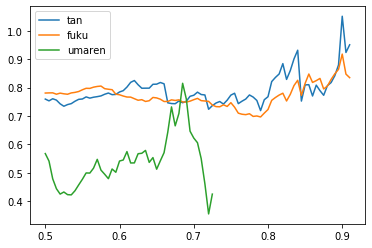

In [681]:
tan.rename('tan').plot(legend=True)
fuku.rename('fuku').plot(legend=True)
umaren.rename('umaren').plot(legend=True)

In [682]:
tan1 = gain(me.tan_return, X_test)
fuku1 = gain(me.fuku_return, X_test)
umaren1 = gain(me.umaren_return, X_test)

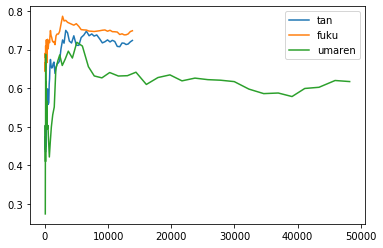

In [658]:
tan1.rename('tan').plot(legend=True)
fuku1.rename('fuku').plot(legend=True)
umaren1.rename('umaren').plot(legend=True)

# 最新の出馬表を取得

In [106]:
# from selenium.webdriver import Chrome, ChromeOptions
# import chromedriver_binary

# class Entry_table:
#     def __init__(self):
#         self.entry_table = pd.DataFrame()
    
#     def scraping_table(self, race_id_list):
#         options = ChromeOptions()
#         driver = Chrome(options=options)
        
#         for race_id in race_id_list:
#             url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
#             driver.get(url)
#             elements = driver.find_elements_by_class_name('HorseList')
#             for element in elements:
#                 tds = element.find_elements_by_tag_name('td')
#                 row = []
#                 for td in tds:
#                     row.append(td.text)
#                     if td.get_attribute('class') in ['HorseInfo', 'Jockey']:
#                         href = td.find_element_by_tag_name('a').get_attribute('href')
#                         row.append(re.findall(r'\d+', href)[0])
#                 self.entry_table = self.entry_table.append(pd.Series(row, name = race_id))
            
#         driver.close()
        
#     def preprocessing(self):
#         df = self.entry_table.copy()
#         df = df[[0,1,3,4,5,6,7,8,10,11,12]]
#         self.entry_table = df
#         self.entry_table = self.entry_table.set_axis(['枠', '馬番','馬名','horse_id','性齢','斤量','騎手','jockey_id','馬体重','予想オッズ','人気'], axis=1)
        
#     def merge_horse_results(self, horse_results, columns, n_race=5):
#         for column in columns:
#             df = horse_results.groupby(level=0).head(n_race)
#             df = df.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
#             df = df.str.split(',', expand=True).add_prefix('{}_'.format(column))
#             self.entry_table = self.entry_table.merge(df, left_on='horse_id', right_index=True, how='left')

In [107]:
et = Entry_table()
et.scraping_table(['202105030609'])
et.preprocessing()
et.entry_table

,枠,馬番,馬名,horse_id,性齢,斤量,騎手,jockey_id,馬体重,予想オッズ,人気
202105030609,1,1,ベスビアナイト,2017105590,セ4,54.0,菅原明,01179,490(+2),6.7,5
202105030609,2,2,エドノフェリーチェ,2017104060,牝4,54.0,津村,01092,448(-4),5.1,3
202105030609,3,3,ライル,2016104868,セ5,55.0,石川,01150,490(-10),25.6,7
202105030609,4,4,アスティ,2016104998,セ5,54.0,江田照,00689,430(+4),49.4,9
202105030609,5,5,エカテリンブルク,2017105500,牡4,54.0,石橋脩,01077,510(+4),35.9,8
202105030609,6,6,ディスカバー,2014105545,セ7,53.0,原,01184,466(-2),201.3,11
202105030609,6,7,ドリームスピリット,2015102790,牡6,54.0,ルメール,05339,500(-2),6.5,4
202105030609,7,8,ヒルノダカール,2016100550,牡5,56.0,北村宏,01043,512(+4),11.1,6
202105030609,7,9,ペレ,2016104614,牝5,54.0,Ｍデムーロ,05212,456(-2),3.7,2
202105030609,8,10,レッドクーゲル,2016103041,牡5,53.0,吉田豊,00733,440(-4),80.7,10


## EntryTableクラス

In [398]:
class EntryTable():
    def __init__(self):
        self.entry_tables = pd.DataFrame()
        self.entry_tables_p = pd.DataFrame()
        self.entry_tables_hr = pd.DataFrame()
        self.entry_tables_ped = pd.DataFrame()
        self.entry_tables_cat = pd.DataFrame()
        
    def scraping(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            #馬場情報などを取得
            texts = soup.find('div',attrs=['class','RaceData01']).text
            texts = re.findall(r'\w+', texts)

            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])]*len(df)
                if text in ['良','稍重','重']:
                    df['ground_state'] = [text]*len(df)
                if '不' in text:
                    df['ground_state'] = ['不良']*len(df)
                if '芝' in text:
                    df['race_type'] = ['芝']*len(df)
                if '障' in text:
                    df['race_type'] = ['障害']*len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート']*len(df)
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    df['weather'] = [text]*len(df)

            df['date'] = [date]*len(df)

            #horse_idとjockey_id取得
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)

            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)

            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id]*len(df)
            self.entry_tables = self.entry_tables.append(df)

    def preprocessing(self):
        df = self.entry_tables.copy() 
        #性齢を性と齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
        #馬体重を体重と体重増減に分ける
        df["体重"] = df["馬体重(増減)"].str.split('(',expand=True)[0].astype(int)
        df["体重増減"] = df["馬体重(増減)"].str.split('(',expand=True)[1].str[:-1].astype(int)
        
        df['date'] = pd.to_datetime(df['date'])
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df = df[['枠', '馬番', '斤量', 'horse_id', 'jockey_id', 
                 'course_len', 'date', 'ground_state', 'race_type', 'weather', 
                 '性', '齢', '体重', '体重増減']]
        self.entry_tables_p = df.rename(columns={'枠':'枠番'})
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.entry_tables_hr = self.entry_tables_p.copy()
        for n_samples in n_samples_list:
            self.entry_tables_hr = hr.merge_all(self.entry_tables_hr, n_samples=n_samples)
            
    def merge_peds(self, peds):
        self.entry_tables_ped = self.entry_tables_hr.merge(peds, left_on='horse_id', right_index=True, how='left')
        
    def process_cat(self, le_horse, le_jockey, results):
        df = self.entry_tables_ped.copy()
        
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique() #過去レースデータにないhorse_idを特定
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id']) #0始まりの数字に変換
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique() #過去レースデータにないjockey_idを特定
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id']) #0始まりの数字に変換
        
        weathers = results['weather'].unique()
        race_type = results['race_type'].unique()
        ground_state = results['ground_state'].unique()
        sexes = results['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_type)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_state)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.entry_tables_cat = df

## 出馬表取得

In [399]:
et = EntryTable()
et.scraping(['202105030602'], '2021/06/20')

## 前処理

In [321]:
et.preprocessing()

## 馬ごとの過去成績をマージ

In [322]:
hr = HorseResults(horse_results)
et.merge_horse_results(hr)
# et.entry_tables_hr

## 血統データを更新して出馬表にマージ

In [224]:
#出馬する馬のリスト
update_id_list = et.entry_tables_ped['horse_id'].values
update_id_list

array(['2018100356', '2018106418', '2018103250', '2018105822',
       '2018105703', '2018101102', '2018105850', '2018105756',
       '2018105587', '2018100595', '2018103224', '2018105447',
       '2018104594', '2018103328'], dtype=object)

In [297]:
#出馬する馬のうち、取得済み血統データにない馬のみ血統データを取得
new_peds = update(scraping_peds, update_id_list, peds, merge=False)
new_peds

{'2018105447': 0     ノヴェリスト Novellist(愛) 2009 黒鹿毛 [血統][産駒] Blandford系
 1                  メモリアルサマー 1998 青毛 [血統][産駒] FNo.[9-f]
 2                             Monsun 1990 黒鹿毛 [血統][産駒]
 3                       Night Lagoon 2001 黒鹿毛 [血統][産駒]
 4        サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒]
                             ...                       
 57                                         Priddy Fair
 58                                            Ambiorix
 59                                            Striking
 60                                           Determine
 61                                       Fanciful Miss
 Name: 2018105447, Length: 62, dtype: object,
 '2018100356': 0     バトルプラン Battle Plan(米) 2005 鹿毛 [血統][産駒] Mr. Pro...
 1                   バクシンオージョ 2004 鹿毛 [血統][産駒] FNo.[1-w]
 2           エンパイアメーカー Empire Maker(米) 2000 黒鹿毛 [血統][産駒]
 3                             Flanders 1992 栗毛 [血統][産駒]
 4                              タイキシャトル 1994 栗毛 [血統][産駒]
                         

In [298]:
#取得した血統データを既に取得済みの血統データにマージ
new_peds = pd.concat([new_peds[horse_id] for horse_id in new_peds], axis=1).T
new_peds = new_peds.add_prefix('peds_')
new_peds

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018105447,ノヴェリスト Novellist(愛) 2009 黒鹿毛 [血統][産駒] Blandford系,メモリアルサマー 1998 青毛 [血統][産駒] FNo.[9-f],Monsun 1990 黒鹿毛 [血統][産駒],Night Lagoon 2001 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],サマーワイン 1990 黒鹿毛 [血統][産駒],Konigsstuhl 1976 青毛 [血統][産駒],Mosella 1985 鹿毛 [血統][産駒],Lagunas 1981 黒鹿毛 [血統][産駒],Nenuphar 1994 黒鹿毛 [血統][産駒],...,Montparnasse,Edelweiss,Kalamoun,State Pension,Hornbeam,Priddy Fair,Ambiorix,Striking,Determine,Fanciful Miss
2018100356,バトルプラン Battle Plan(米) 2005 鹿毛 [血統][産駒] Mr. Pro...,バクシンオージョ 2004 鹿毛 [血統][産駒] FNo.[1-w],エンパイアメーカー Empire Maker(米) 2000 黒鹿毛 [血統][産駒],Flanders 1992 栗毛 [血統][産駒],タイキシャトル 1994 栗毛 [血統][産駒],ファゼンデイロ 1994 鹿毛 [血統][産駒],Unbridled 1987 鹿毛 [血統][産駒],Toussaud 1989 黒鹿毛 [血統][産駒],Seeking the Gold 1985 鹿毛 [血統][産駒],Starlet Storm 1987 栗毛 [血統][産駒],...,Thatch,Contrail,Red God,Runaway Bride,Roberto,Icy Blast,Never Bend,Hill Shade,Lyphard,Irish Star
2018105756,ジョーカプチーノ 2006 芦毛 [血統][産駒] Halo系,ヒカルウェイブ 2001 黒鹿毛 [血統][産駒] FNo.[3-n],マンハッタンカフェ 1998 青鹿毛 [血統][産駒],ジョープシケ 2000 芦毛 [血統][産駒],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ブルーデキシー 1994 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],サトルチェンジ Subtle Change(愛) 1988 黒鹿毛 [血統][産駒],フサイチコンコルド 1993 鹿毛 [血統][産駒],ジョーユーチャリス 1988 芦毛 [血統][産駒],...,Preciptic,Campanette,Princely Gift,Suncourt,ネヴァービート,スターハイネス,Nijinsky,シル,エンペリー,Some Progress
2018105850,ヘニーヒューズ Henny Hughes(米) 2003 [血統][産駒] Storm Bird系,メイショウスザンナ 2009 鹿毛 [血統][産駒] FNo.[4-j],ヘネシー Hennessy(米) 1993 栗毛 [血統][産駒],Meadow Flyer 1989 鹿毛 [血統][産駒],アグネスデジタル 1997 栗毛 [血統][産駒],グリーンオリーヴ 1997 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Island Kitty 1976 栗毛 [血統][産駒],Meadowlake 1983 栗毛 [血統][産駒],Shortley 1980 黒鹿毛 [血統][産駒],...,Alleged,Runaway Bride,Hail to Reason,Cosmah,Understanding,Mountain Flower,Nijinsky,シル,Sicambre,Fee Royale
2018100595,キンシャサノキセキ 2003 鹿毛 [血統][産駒] Halo系,メイショウシオギリ 2004 鹿毛 [血統][産駒] FNo.[1-d],フジキセキ 1992 青鹿毛 [血統][産駒],ケルトシャーン Keltshaan(米) 1994 鹿毛 [血統][産駒],メイショウドトウ 1996 鹿毛 [血統][産駒],メイショウエビータ 1995 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ミルレーサー Millracer(米) 1983 鹿毛 [血統][産駒],Pleasant Colony 1978 黒鹿毛 [血統][産駒],Featherhill 1978 鹿毛 [血統][産駒],...,Nijinsky,Fast Approach,Mr. Prospector,Mudville,Reflected Glory,Blue Eyed Blonde,Best Turn,Our Martha,Northern Dancer,Desert Flight
2018103328,ヤマニンセラフィム 1999 栗毛 [血統][産駒] Halo系,ヤマニンジャルダン 2003 鹿毛 [血統][産駒] FNo.[2],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ヤマニンパラダイス 1992 鹿毛 [血統][産駒],マイネルラヴ 1995 青鹿毛 [血統][産駒],ヤマニンカーニバル 1994 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Danzig 1977 鹿毛 [血統][産駒],Althea 1981 栗毛 [血統][産駒],...,Secretariat,Arachne,Ribot,Pocahontas,Bold Reasoning,Tomorrowland,Vice Regent,Miss Attractive,マルゼンスキー,パンクチェイシヨン
2018104594,ハーツクライ 2001 鹿毛 [血統][産駒] Halo系,クォリティシーズン 2008 黒鹿毛 [血統][産駒] FNo.[23-b],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],アイリッシュダンス 1990 鹿毛 [血統][産駒],トワイニング Twining(米) 1991 栗毛 [血統][産駒],コンファームドダンサー Confirmed Dancer(米) 1986 青鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ビューパーダンス Buper Dance(米) 1983 黒鹿毛 [血統][産駒],...,War Admiral,Judy-Rae,Northern Dancer,Flaming Page,Val de Loir,Sly Pola,Never Bend,Roman Song,Cornish Prince,Won't Tell You


In [279]:
peds.index.nunique()

11389

In [299]:
new_peds1 = pd.concat([new_peds, peds])
new_peds1.index.nunique()

11396

In [327]:
#Pedsクラスに入れてcategory型に変換
p = Peds(new_peds1)
p.encode()
new_peds1 = p.peds_en

In [330]:
#出馬表にマージ
et.merge_peds(new_peds1)
et.entry_tables_ped

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,ground_state,race_type,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202105030602,1,1,52,2018100356,01164,1600,2021-06-20,不良,ダート,晴,...,336,122,132,298,346,367,249,432,504,1088
202105030602,2,2,54,2018106418,00689,1600,2021-06-20,不良,ダート,晴,...,209,135,22,214,265,107,84,46,115,1839
202105030602,3,3,54,2018103250,00684,1600,2021-06-20,不良,ダート,晴,...,121,630,62,61,444,526,488,1156,1200,2805
202105030602,3,4,54,2018105822,01162,1600,2021-06-20,不良,ダート,晴,...,121,630,62,61,444,526,46,954,403,341
202105030602,4,5,54,2018105703,01122,1600,2021-06-20,不良,ダート,晴,...,144,658,63,370,501,899,260,533,204,469
202105030602,4,6,54,2018101102,01127,1600,2021-06-20,不良,ダート,晴,...,189,399,114,254,339,455,492,1179,1090,2728
202105030602,5,7,54,2018105850,01154,1600,2021-06-20,不良,ダート,晴,...,6,515,62,61,444,526,253,1154,801,727
202105030602,5,8,54,2018105756,01118,1600,2021-06-20,不良,ダート,晴,...,254,85,124,334,509,927,253,1154,1052,2143
202105030602,6,9,54,2018105587,01158,1600,2021-06-20,不良,ダート,晴,...,75,367,124,334,509,927,260,533,164,1479
202105030602,6,10,54,2018100595,00733,1600,2021-06-20,不良,ダート,晴,...,225,183,101,223,331,100,32,712,601,559


In [329]:
le_horse = LabelEncoder().fit(results['horse_id'])
le_jockey = LabelEncoder().fit(results['jockey_id'])

In [331]:
et.process_cat(le_horse, le_jockey, results_p)
et.entry_tables_cat

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,齢,体重,体重増減,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牝,性_牡,性_セ
202105030602,1,1,52,11389,114,1600,2021-06-20,3,474,0,...,0,1,0,0,0,1,0,1,0,0
202105030602,2,2,54,11044,8,1600,2021-06-20,3,454,2,...,0,1,0,0,0,1,0,1,0,0
202105030602,3,3,54,9523,7,1600,2021-06-20,3,472,-2,...,0,1,0,0,0,1,0,1,0,0
202105030602,3,4,54,10810,112,1600,2021-06-20,3,476,0,...,0,1,0,0,0,1,0,1,0,0
202105030602,4,5,54,10768,78,1600,2021-06-20,3,432,-6,...,0,1,0,0,0,1,0,1,0,0
202105030602,4,6,54,8623,83,1600,2021-06-20,3,452,-2,...,0,1,0,0,0,1,0,1,0,0
202105030602,5,7,54,11390,105,1600,2021-06-20,3,436,12,...,0,1,0,0,0,1,0,1,0,0
202105030602,5,8,54,11391,75,1600,2021-06-20,3,424,-6,...,0,1,0,0,0,1,0,1,0,0
202105030602,6,9,54,10716,108,1600,2021-06-20,3,446,4,...,0,1,0,0,0,1,0,1,0,0
202105030602,6,10,54,11392,14,1600,2021-06-20,3,466,-4,...,0,1,0,0,0,1,0,1,0,0


In [339]:
et.entry_tables_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 202105030602 to 202105030602
Data columns (total 94 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   枠番               14 non-null     int32         
 1   馬番               14 non-null     int32         
 2   斤量               14 non-null     int32         
 3   horse_id         14 non-null     int32         
 4   jockey_id        14 non-null     int32         
 5   course_len       14 non-null     int64         
 6   date             14 non-null     datetime64[ns]
 7   齢                14 non-null     int32         
 8   体重               14 non-null     int32         
 9   体重増減             14 non-null     int32         
 10  着順_5R            7 non-null      float64       
 11  賞金_5R            7 non-null      float64       
 12  着順_9R            7 non-null      float64       
 13  賞金_9R            7 non-null      float64       
 14  着順_allR          7 non-null 

## 予測

In [361]:
X_test = et.entry_tables_cat.drop(['date','着順_9R','賞金_9R','着順_allR','賞金_allR'], axis=1)

me.predict_proba(X_test)

202105030602    0.090427
202105030602    0.208541
202105030602    0.000962
202105030602    0.473869
202105030602    0.070881
202105030602    0.091505
202105030602    0.273849
202105030602    0.989310
202105030602    0.449469
202105030602    0.000000
202105030602    0.266361
202105030602    0.402870
202105030602    0.155700
202105030602    1.000000
dtype: float64